In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import*

In [3]:
path = Path('/home/jupyter/.fastai/data/camvid-tiramisu')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/models'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/testannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/trainannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train')]

In [5]:
# Data

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08093.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08059.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_07983.png')]

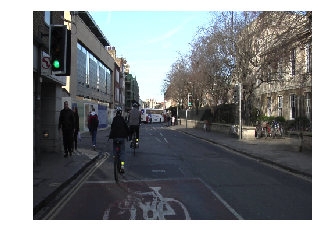

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

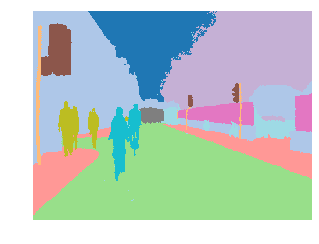

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [11]:
# Datasets

In [12]:
bs,size = 8,src_size//2

In [13]:
src = (SegmentationItemList.from_folder(path)
      .split_by_folder(valid='val')
      .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

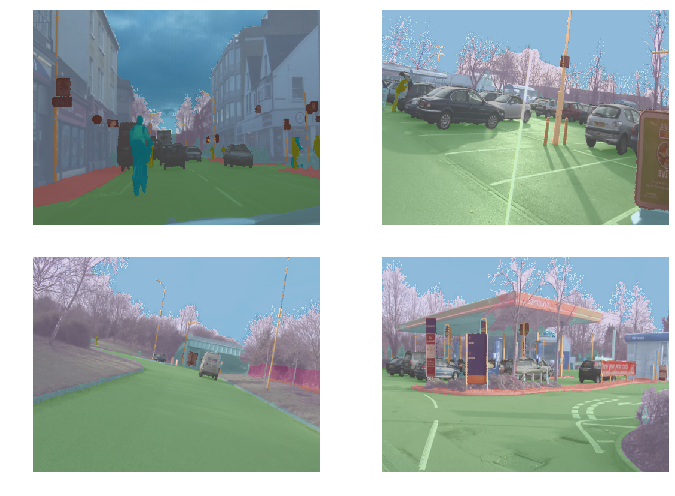

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
# Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask])

In [18]:
metrics=acc_camvid
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [ ]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
lr=2e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)